In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [56]:
from scipy.io import loadmat, savemat
from matplotlib.ticker import LogFormatter 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook as tqdm
import os
import edamame.core.wires as wires
from IPython.core.debugger import set_trace
# import nct
import bct
import pandas as pd

import pickle 
import _pickle as cPickle
import gzip
import matplotlib.colors as clrs


def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f,encoding="bytes") #change this for python 2
        return loaded_object

In [3]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [4]:
dataLoc='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/ModularNWNs/VSweep/'
saveFig='/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'

In [5]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300nw_2_modules_10sets_NWN.pkl'
NWN=decompress_pickle(name)
name2='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300nw_2_modules_separated_10sets_NWN.pkl'
NWN_separate=decompress_pickle(name2)

In [25]:
graph=[[] for i in range(len(NWN))]
adjMat=[[] for i in range(len(NWN))]

for nw in range(len(NWN)):
    nwnGraph=NWN[nw][5]['G']
    numNWs=6
    nws=np.linspace(0,8,6)

    #Loop through rewiring from completely modular to completely integrated
    for i in tqdm(range(numNWs)):
        if i == 0:
            graph[nw].append((nwnGraph.copy()))
            currGraph=graph[nw][i]
        else:
            currGraph=graph[nw][i-1].copy()
        temp=[]
        temp=nx.double_edge_swap(currGraph,nswap=int(np.exp(nws[i])),max_tries=10000,seed=10)
        temp.remove_edges_from(list(nx.selfloop_edges(temp)))
        if i > 0:
            graph[nw].append(max(connected_component_subgraphs(temp), key=len))
        adjMat[nw].append(nx.adjacency_matrix(graph[nw][i]))

In [24]:
#sep graphs:

graphNLT=[]
graphMC=[]
for j in range(10):
    temp=decompress_pickle(dataLoc+'NWN_Network_2modules_separated_10sets_'+str(j+1)+'.pkl')
    Connectivity1=temp[0]
    Connectivity2=temp[1]
    graphNLT.append(nx.from_numpy_matrix(Connectivity1.adj_matrix))
    graphMC.append(nx.from_numpy_matrix(Connectivity2.adj_matrix))


In [6]:
#2 Electrodes
electrodes=[[73,115,173,264],[88,38,229,282],[64,123,193,240],[149,24,247,217],[128,138,190,216],[134,137,236,230],[71,104,191,242],[122,97,187,202],[57,2,166,169],[2,11,215,236]]
electrodes_separate=[[73,115,173-150,264-150],[88,38,229-150,282-150],[64,123,193-150,240-150],[149,24,247-150,217-150],[128,138,190-150,216-150],[134,137,236-150,230-150],[71,104,191-150,242-150],[122,97,187-150,202-150],[57,2,166-150,169-150],[2,11,215-150,236-150]]

#4 Electrodes
# electrodes=[25,22,295,288]#[117, 98, 171, 168]## Electrodes in each module

In [71]:
temp=loadmat(dataLoc+'Module Data Modular NWNs.mat')
module1=temp['Mod1']
module2=temp['Mod2']

In [8]:
### RUN TASKS

In [14]:
onAmp=[0.2,0.5,0.75,1,1.25,1.5,1.75,2,3,5,10]#np.linspace(0,10,201)
voltNames=['0p2','0p5','0p75','1','1p25','1p5','1p75','2','3','5','10']

In [10]:
def MC_k_new(network, k = 1, node_list=[], transient = 100):
#     node_list=n_outs#len(node_list)
    signal = network.stimulus[0].signal[transient:]
    wire_voltage = network.wireVoltage[transient:]
    T, N = wire_voltage.shape
#     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    
    lhs = wire_voltage[k:,node_list]
    rhs = signal[:-k]
    try:
        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
        result = np.matmul(lhs, weight)
        mc = (np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result))
        return mc
    except:
        return 0

In [11]:
def nonLinearTrans_specificNodes(network, targetType, nodesList, repeats = 1):
    """
    targetType can be DoubleFrequency and all other possible biasType.
    wireVoltage[T,N] can also be the first positional parameter.
    """
    from edamame.core.simSettings import stimulus__

    if targetType == 'DoubleFrequency':
        target = stimulus__(network.stimulus[0].biasType, network.TimeVector, f = 2*network.stimulus[0].f).signal
    else:
        target = stimulus__(targetType, network.TimeVector, f = network.stimulus[0].f).signal
        
    wireVoltage = network.wireVoltage    
    T, N = wireVoltage.shape
    output = dict()
    accuracy = np.zeros(repeats)
    weight = np.zeros((repeats, len(nodesList)+1))
    result = np.zeros((repeats, T))
    
    for i in range(repeats):
        lhs = np.hstack((np.ones((T, 1)), wireVoltage[:,nodesList]))
        weight[i,:] = np.linalg.lstsq(lhs, target, rcond = None)[0]
        result[i,:] = np.dot(lhs, weight[i,:])
        accuracy[i] = 1-getRNMSE(result[i,:], target)
        
    output['weight'] = np.mean(weight, axis = 0)
    output['result'] = np.mean(result, axis = 0)
    output['accuracy'] = np.mean(accuracy)
    output['target'] = target
    
    return output 

In [19]:
seed

NameError: name 'seed' is not defined

In [20]:
def get_MC_and_NLT(j,k,elecs,module1,module2,seed=[],noiseOn=False,saveTimeSeries=False,amp = 2, dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False):
    ampName=str(amp).replace('.','p')
    f=0.5

    Connectivity=decompress_pickle(dataLoc+'NWN_Network_2modules_Rewired_'+str(j+1)+'_'+str(k+1)+'.pkl')
    Graph= nx.from_numpy_matrix(Connectivity.adj_matrix)
    
    np.random.seed(seed)
    
    stimulus=[]
    stimulus.append(stimulus__(biasType='AC',onAmp=amp,TimeVector=np.arange(0,10,dt),f=f))
    stimulus.append(stimulus__(biasType='Drain',TimeVector=np.arange(0,10,dt))) #we don't want this drain to be active during training
    stimulus.append(stimulus__(biasType='Custom',TimeVector=np.arange(0,10,dt),customSignal=signal_expand(np.random.random(1000)*2*amp-amp, dur)))
    stimulus.append(stimulus__(biasType='Drain',TimeVector=np.arange(0,10,dt))) #we don't want this drain to be active during training
    #White noise
    if noiseOn:
        noise=[gauss(0.0, 1.0) for i in range(1000)]
        stimulus.append(stimulus__(biasType='Custom',TimeVector=np.arange(0,10,dt),customSignal=signal_expand(noise, dur)))
    
    simRAND = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                start_state =  init_state,
                stimulus=stimulus,
                onAmp=amp,
                junctionMode = 'tunneling', 
                contactMode = 'preSet',
                electrodes=elecs,
                findFirst=False, disable_tqdm=True)
    
#     print(len(simRAND.junctionConductance))
    output={'JunctionConductance':simRAND.junctionConductance,'JunctionVoltage':simRAND.junctionVoltage,'Switch':simRAND.junctionSwitch,'Source':simRAND.sources[0:2],'Drain':simRAND.drains[0:2],'Signal':simRAND.stimulus}
    if saveTimeSeries==True:
        compressed_pickle(output,dataLoc+'NLT+MC_MultitaskingFullTimeSeries_seed10_'+'REWIRED_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')

    nodesList=[]
    if elecs[2] in module1[k][0]:   #if the MC electrode is in module one, we only want to sample from those nodes
        nodesList=module1[k][0] #only want nodes in first module
    else:
        nodesList=module2[k][0]
        
    mcRAND = [MC_k_new(simRAND, l, node_list=nodesList) for l in range(dur, len(nodesList)*dur, dur)]
    
    nodesList=[]
    if elecs[0] in module1[k][0]:   #if the NLT electrode is in module one, we only want to sample from those nodes
        nodesList=module1[k][0] #only want nodes in first module
    else:
        nodesList=module2[k][0]
    
    nwSqu =[None]*len(nodesList)

    countK=0

    ResultSqu = nonLinearTrans_specificNodes(simRAND,'Square',nodesList, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
    nwSqu=ResultSqu['accuracy']
    
    if return_sim:
        return np.sum(mcRAND), simRAND, nwSqu
    else:
        return np.sum(mcRAND),nwSqu

In [497]:
noiseOn=False #Add white noise?

if noiseOn:
    elecs=electrodesNoise
else:
    elecs=electrodes
initMCNLT=[[] for i in range(10)]
seed=np.arange(10,21) #10 different seeds
for nTimes in tqdm(range(10)): #for 10 times
    if nTimes==9:
        saveTimeSeries=True
    else:
        saveTimeSeries=False
    for i in (range(len(onAmp))): #for each voltage
        for j in range(len(graph)): #for each network
            for k in [0,5]: #for each modularity (integrated or segregated only)
                initMCNLT[nTimes].append(inputPacker(get_MC_and_NLT,j,k,electrodes[j],module1[j],module2[j],seed=seed[nTimes],noiseOn=noiseOn,amp=onAmp[i],saveTimeSeries=saveTimeSeries))

In [498]:
get_MC_and_NLT(5,5,electrodes[5],module1[5],module2[5],seed=seed[0],noiseOn=noiseOn,amp=onAmp[4])

(103.01170494746175, 0.6864189623129097)

In [500]:
#Run
resultMCNLT=[None]*10
for i in tqdm(range(10)):
    resultMCNLT[i]=(para_run(get_MC_and_NLT,initMCNLT[i],nCPU=10,start_method='fork'))

In [ ]:
# [MC,NLT]=decompress_pickle(dataLoc+'MovieDataMC+NLT.pkl')

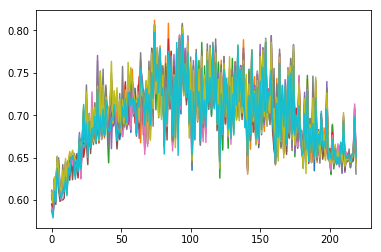

In [501]:
plt.plot(np.array(resultMCNLT[:]).T[1])

In [9]:
[MC_same,NLT_same]=decompress_pickle(dataLoc+'MC+NLT_RewiredModularityResults_seed10')

In [10]:
NLT_same=NLT_same.reshape(11,60)
MC_same=MC_same.reshape(11,60)

In [11]:
NLT_same=np.fliplr(NLT_same)
MC_same=np.fliplr(MC_same)

In [12]:
NLT_same=NLT_same.reshape(11,10,6)
MC_same=MC_same.reshape(11,10,6)

In [15]:
MultiTask_sims=[[[] for j in range(len(NWN))] for i in range(len(onAmp))]
for volt in tqdm(range(len(onAmp))):
    for i in range(len(NWN)):
        for j in [0,5]: #for each modularity (integrated or segregated only)
            name2=dataLoc+'NLT+MC_Electrodes_seed10_'+'REWIRED_'+str(i+1)+'_'+str(j+1)+'_'+voltNames[volt]+'v.pkl'
            MultiTask_sims[volt][i].append(decompress_pickle(name2))

In [17]:
MC_sep=[[[] for j in range(len(NWN))] for i in range(len(onAmp))]
for volt in tqdm(range(len(onAmp))):
    for i in range(len(NWN)):
        name2=dataLoc+'MC_ElectrodesSeparated_seed10_'+'2modules_Rewired_Network_'+str(i+1)+'_'+voltNames[volt]+'v.pkl'
        MC_sep[volt][i].append(decompress_pickle(name2))

In [18]:
NLT_sep=[[[] for j in range(len(NWN))] for i in range(len(onAmp))]
for volt in tqdm(range(len(onAmp))):
    for i in range(len(NWN)):
        name2=dataLoc+'NLT_ElectrodesSeparated_seed10_'+'2modules_Rewired_Network_'+str(i+1)+'_'+voltNames[volt]+'v.pkl'
        NLT_sep[volt][i].append(decompress_pickle(name2))

In [29]:
# MC=np.mean(MC,axis=0)
# NLT=np.mean(NLT,axis=0)

In [30]:
# MC=np.array(np.double(MC)).reshape(11,20)
# NLT=np.array(np.double(NLT)).reshape(11,20)

In [31]:
# compressed_pickle([MC,NLT],dataLoc+'MovieDataMC+NLT.pkl')

In [32]:
# MC=np.array(np.double(MC)).reshape(11,2,10)
# NLT=np.array(np.double(NLT)).reshape(11,2,10)

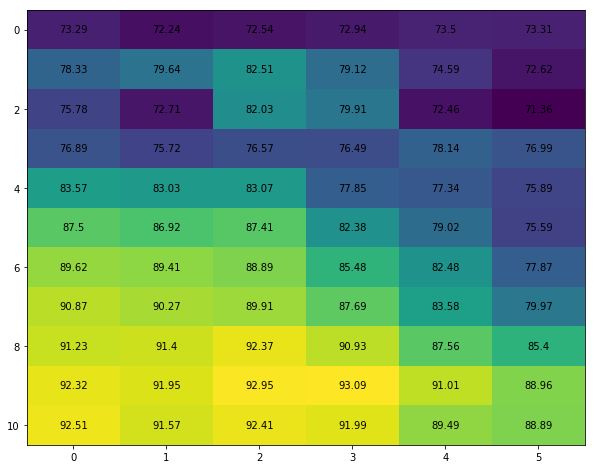

In [16]:
plt.figure(figsize=(10,8))
plt.imshow(np.mean(MC_same,axis=1),aspect='auto')
for (j,i),label in np.ndenumerate((np.mean(MC_same,axis=1))):
    plt.text(i,j,np.around(label,2),ha='center',va='center',color='k')

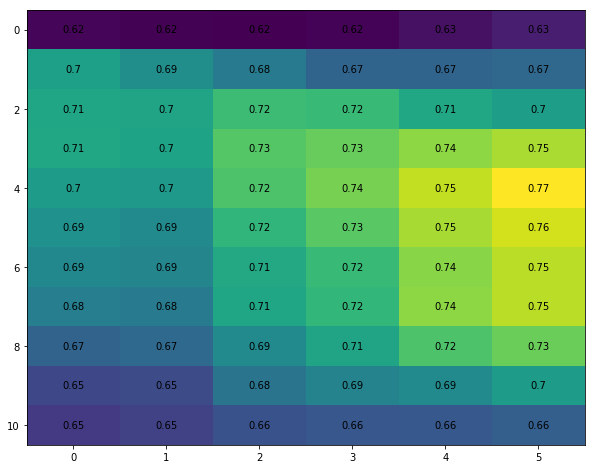

In [34]:
plt.figure(figsize=(10,8))
plt.imshow(np.mean(NLT_same,axis=1),aspect='auto')
for (j,i),label in np.ndenumerate((np.mean(NLT_same,axis=1))):
    plt.text(i,j,np.around(label,2),ha='center',va='center',color='k')

In [362]:
# MultiTask_sims_lastTimeframe=[[[] for j in range(len(NWN))] for i in range(len(onAmp))]
# for volt in tqdm(range(len(onAmp))):
#     for i in range(len(NWN)):
#         for j in range(numNWs): #for each modularity (integrated or segregated only)
#             name2=dataLoc+'NLT+MC_Electrodes_seed10_'+'REWIREDNetworkComparison_'+str(i+1)+'_'+str(j+1)+'_'+voltNames[volt]+'v.pkl'
#             MultiTask_sims_lastTimeframe[volt][i].append(decompress_pickle(name2))

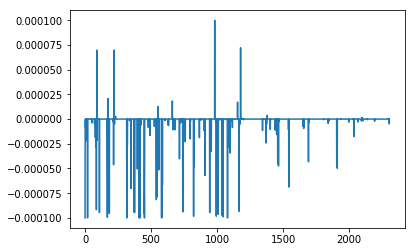

In [29]:
plt.plot(MultiTask_sims[5][0][0]['JunctionConductance'][550]-MultiTask_sims[5][0][0]['JunctionConductance'][500])

In [19]:
def getWeightedGraph(sims,network,edgeList,numWires,time):#, this_TimeStamp = 0):
#     edgeList = network['edge_list']
    adjMat = np.zeros((numWires, numWires))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = sims['JunctionConductance'][time]#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = sims['JunctionConductance'][time]#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    WeightedGraph = nx.from_numpy_array(adjMat)
    WeightedGraph=nx.DiGraph.to_undirected(WeightedGraph)
    
    return WeightedGraph

In [20]:
from IPython.display import clear_output

In [21]:
def image_draw_sep(nwnum,newOnAmp,minWeights,maxWeights,time,task):
#     ax.clear()

    if task == 'NLT':
        sim=NLT_sep[newOnAmp][nwnum][0]
        graph=graphNLT[nwnum]
    elif task == 'MC':
        sim=MC_sep[newOnAmp][nwnum][0]
        graph=graphMC[nwnum]
    else:
        print('NLT or MC tasks only')
        
    if time == 0:
        sys.stdout.flush()
        sys.stdout.write("\b" * (1000+1)) # return to start of line, after '['
    sys.stdout.write('\r'+str(np.around((time/1000)*100,2))+'%')
    sys.stdout.flush()
    #use sample network to show functional graph
    network=np.array(nx.adjacency_matrix(graph).todense()) 
    sources=sim['Source']
    drains=sim['Drain']
    OGgraph=graph.copy()
    pos=nx.kamada_kawai_layout(OGgraph)
    numWires=graph.number_of_nodes()
    edgeList=np.array(list(graph.edges()))
    weightedSubGraph=getWeightedGraph(sim,network,edgeList,numWires,time)
            
    #Draw:
    G=weightedSubGraph
    edge_weights=nx.get_edge_attributes(G,'weight')
    G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-6)) 
    edges=G.edges()
    weights=[G[u][v]['weight'] for u,v in edges]
    
    #draw OG graph
    pos=nx.kamada_kawai_layout(OGgraph)
    h=nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=10,ax=ax)
    h.set_zorder(1)

    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=weights,edge_cmap=plt.cm.inferno,edge_vmin=minWeights,edge_vmax=maxWeights)
    if h2:
        h2.set_norm(clrs.SymLogNorm(10))
        h2.set_zorder(3)
#             if j == 10 and i == 6:
#                 plt.colorbar(h2)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=sources,node_color='#3f9b0b',node_size=120,node_shape ='*',ax=ax)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=drains,node_color='#7e1e9c',node_size=120,node_shape ='*',ax=ax)
    ax.set_frame_on(False)

    ax.set_yticks([])
    ax.set_xticks([])

In [84]:
def image_draw(nwnum,newOnAmp,mod,minWeights,maxWeights,time):
#     ax.clear()
    if time == 0:
        sys.stdout.flush()
        sys.stdout.write("\b" * (1000+1)) # return to start of line, after '['
    sys.stdout.write('\r'+str(np.around((time/1000)*100,2))+'%')
    sys.stdout.flush()
    #use sample network to show functional graph
    sim=MultiTask_sims[newOnAmp][nwnum][mod]
    if mod == 1:
        graphmod=5
    else:
        graphmod=0
    network=np.array(nx.adjacency_matrix(graph[nwnum][graphmod]).todense()) 
    sources=sim['Source']
    drains=sim['Drain']
    OGgraph=graph[nwnum][graphmod].copy()
    pos=nx.kamada_kawai_layout(OGgraph)
    numWires=graph[nwnum][graphmod].number_of_nodes()
    edgeList=np.array(list(graph[nwnum][graphmod].edges()))
    weightedSubGraph=getWeightedGraph(sim,network,edgeList,numWires,time)

#     maxNW=np.argmax(MultiTask_sims[newOnAmp][nwnum][mod])
#     minNW=np.argmin(MultiTask_sims[newOnAmp][nwnum][mod])
#     G=weightedSubGraph
#     edges=G.edges()
#     weights1=[G[u][v]['weight'] for u,v in edges]
            
    #Draw:
    G=weightedSubGraph
    edge_weights=nx.get_edge_attributes(G,'weight')
    G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-6)) 
    edges=G.edges()
    weights=[G[u][v]['weight'] for u,v in edges]
    
    #draw OG graph
    pos=nx.kamada_kawai_layout(OGgraph)
    h=nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=10,ax=ax)
    h.set_zorder(1)

    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=weights,edge_cmap=plt.cm.inferno,edge_vmin=minWeights,edge_vmax=maxWeights)
    if h2:
        h2.set_norm(clrs.SymLogNorm(10))
        h2.set_zorder(3)
#             if j == 10 and i == 6:

    nx.draw_networkx_nodes(G,pos=pos,nodelist=sources,node_color='#3f9b0b',node_size=120,node_shape ='*',ax=ax)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=drains,node_color='#7e1e9c',node_size=120,node_shape ='*',ax=ax)
    ax.set_frame_on(False)

    ax.set_yticks([])
    ax.set_xticks([])


In [81]:
time

0

10.0%

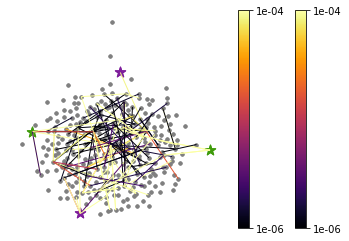

In [83]:
fig,ax=plt.subplots(1)
image_draw(1,2,1,1e-7,1e-4,999)
image_draw(1,2,1,1e-7,1e-4,100)

plt.show()

In [50]:
import matplotlib
from matplotlib import animation
from PIL import Image

0.0%

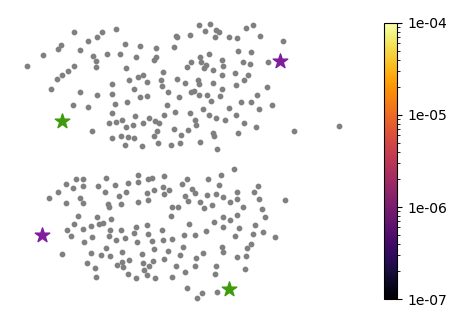

In [182]:
#Generate Movie 

nwnum=1
newOnAmp=4 #[1,3,4]
mod=0
time=0
minWeights=1e-7
maxWeights=1e-4

f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(5, 4), dpi=100)
canvas_width, canvas_height = f.canvas.get_width_height()
ax.axis('off')
cax.axis('off')

#This is a dirty work around for a colorbar
clrplt=np.linspace(minWeights,maxWeights,2).reshape(2,1)
img=cax.imshow(clrplt,cmap=plt.cm.inferno,norm=clrs.LogNorm())
cax.set_visible(False)
formatter = LogFormatter(10, labelOnlyBase=False) 
plt.colorbar(img,ax=cax,cmap=plt.cm.inferno,fraction=2, pad=0.04,format=formatter)

def animate(time): #animate
    image_draw(nwnum,newOnAmp,mod,minVal,maxVal,time) #nwnum,newOnAmp,mod
anim = animation.FuncAnimation(f, animate, frames=range(1000)[::2], interval=100, repeat=False)

0.0%

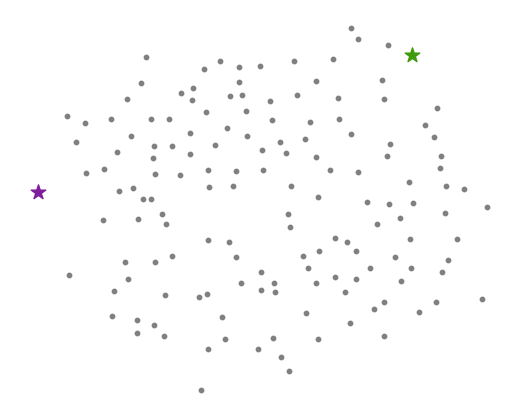

In [131]:
#Generate Movie SEPARATED
task='MC'
nwnum=1
newOnAmp=3 #[1,3,4]
mod=1
time=0

f = plt.figure(frameon=False, figsize=(5, 4), dpi=100)
canvas_width, canvas_height = f.canvas.get_width_height()
ax = f.add_axes([0, 0, 1, 1])
ax.axis('off')
# image=image_draw(nwnum,newOnAmp,mod,1e-6,1e-4,time)
# plt.show()
def animate(time):
    image_draw_sep(nwnum,newOnAmp,1e-7,1e-4,time,task) #nwnum,newOnAmp,mod
   
anim = animation.FuncAnimation(f, animate, frames=range(1000)[::2], interval=100, repeat=False)

In [132]:
matplotlib.rcParams['animation.embed_limit'] = 2**64
# s=anim.to_jshtml(fps=30)
anim.save(saveFig+'nw'+str(nwnum)+'_Separated'+'_animation_'+task+'_'+voltNames[newOnAmp]+'v.gif', writer=animation.PillowWriter(fps=30))


2021-04-14 11:41:22,552:INFO:Animation.save using <class 'matplotlib.animation.PillowWriter'>


99.8%

In [183]:
#Unseparated
matplotlib.rcParams['animation.embed_limit'] = 2**64
anim.save(saveFig+'nw'+str(nwnum)+'_animation_'+voltNames[newOnAmp]+'v.gif', writer=animation.PillowWriter(fps=30))

2021-06-11 11:32:15,500:INFO:Animation.save using <class 'matplotlib.animation.PillowWriter'>


99.8%

In [110]:
#Separated
with open(saveFig+'nw'+str(nwnum)+'_Separated'+'_animation_'+task+'_'+voltNames[newOnAmp]+'v.html', "w") as f:
    f.write(s)